In [5]:
import sqlite3
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import numpy as np


**CREATE THE DATABASE SQL_data.db**

In [3]:
# Step 1: Define column names for each table
Covid_rates_columns = [
    'outcome', 'month', 'MMWR week', 'Age group', 'Vaccine product',
    'Vaccinated with outcome', 'Fully vaccinated population',
    'Unvaccinated with outcome', 'Unvaccinated population', 'Crude vax IR',
    'Crude unvax IR', 'Crude IRR', 'Continuity correction'
]

trans_level_columns = [
    'state_name', 'county_name', 'fips_code', 'date',
    'cases_per_100K_7_day_count_change',
    'percent_test_results_reported_positive_last_7_days',
    'community_transmission_level'
]

# Step 2: Create empty DataFrames for structure
Covid_rates = pd.DataFrame(columns=Covid_rates_columns)
trans_level = pd.DataFrame(columns=trans_level_columns)

# Step 1: Load the CSV files into pandas DataFrames
Covid_rates = pd.read_csv("Data/clean/clean_data_1_updated.csv")
trans_level = pd.read_csv("Data/clean/clean_data_2_updated.csv")


# Step 3: Define the file path for the SQLite database
db_path = "SQL_data.db"

# Step 4: Create SQLite database and save tables
conn = sqlite3.connect("SQL_data.db")

# Save data into respective tables
Covid_rates.to_sql('Covid_rates', conn, index=False, if_exists='replace')
trans_level.to_sql('trans_level', conn, index=False, if_exists='replace')

# Close the database connection
# conn.close()
print(f"Database created and loaded with data from CSV files at {db_path}")

Database created and loaded with data from CSV files at SQL_data.db


In [36]:
# Query the tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:")
print(tables)

# You can also fetch data from the tables
Covid_rates = pd.read_sql_query("SELECT * FROM Covid_rates LIMIT 5;", conn)
print("First 5 rows from Covid_rates table:")
print(Covid_rates)

trans_level = pd.read_sql_query("SELECT * FROM trans_level LIMIT 5;", conn)
print("First 5 rows from trans_level table:")
print(trans_level)

# Close the connection when done
conn.close()

Tables in the database:
          name
0  Covid_rates
1  trans_level
First 5 rows from Covid_rates table:
  outcome     month  MMWR week Age group Vaccine product  \
0    case  APR 2021     202114     12-17       all_types   
1    case  APR 2021     202114     18-29       all_types   
2    case  APR 2021     202114     30-49       all_types   
3    case  APR 2021     202114     50-64       all_types   
4    case  APR 2021     202114     65-79       all_types   

   Vaccinated with outcome  Fully vaccinated population  \
0                        8                      36887.0   
1                      674                    2543093.0   
2                     1847                    7428405.0   
3                     1558                    7487444.0   
4                     1672                   14398099.0   

   Unvaccinated with outcome  Unvaccinated population  Crude vax IR  \
0                      30785               17556462.0     21.687858   
1                      76736        

In [41]:
source = "SQL_data.db"
destination = "Data/"
shutil.move(source, destination)

'Data/SQL_data.db'

**TOTAL CASES BY AGE GROUPS**

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')

# Calculate cases by age group using SQL query
query = """
SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Cases
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Cases DESC;
"""

# Execute the query and load results into a DataFrame
cases_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the result
print(cases_by_age_group)

      Age group  Vaccinated_Cases  Unvaccinated_Cases  Total_Cases
0  all_ages_adj          35736157            83788412    119524569
1         30-49           6037254             6934922     12972176
2         18-29           3235323             5060862      8296185
3         50-64           4071401             3246103      7317504
4         65-79           2336144             1365175      3701319
5         12-17           1064817             2244912      3309729
6          5-11            374167             1687598      2061765
7           80+            758672              407531      1166203


The data reveals the distribution of COVID-19 cases by age group, distinguishing between vaccinated and unvaccinated individuals:

all_ages_adj: Across all age groups, there were approximately 119.5 million cases, with 83.8 million (or about 70% of total cases) unvaccinated cases; while vaccinated cases totaled 35.7 million.

30-49 age group: most affected age group with the highest number of cases (12.97 million total), reflecting a significant portion of the population that is both socially active and potentially less likely to be vaccinated.

18-29 and 12-17 age groups combined account for 11.6 million cases, indicating considerable infection rates among younger populations, particularly the unvaccinated.

65-79 and 80+: reported fewer cases compared to younger groups, likely due to higher vaccination rates and more precautions taken.

Children (5-11): fewer cases (2.06 million) compared to other age groups, possibly reflecting lower transmission rates and/or vaccine availability for children.

Summery: Higher risk of infection among unvaccinated individuals across all age groups and significant contributions of younger, socially active groups to the case.

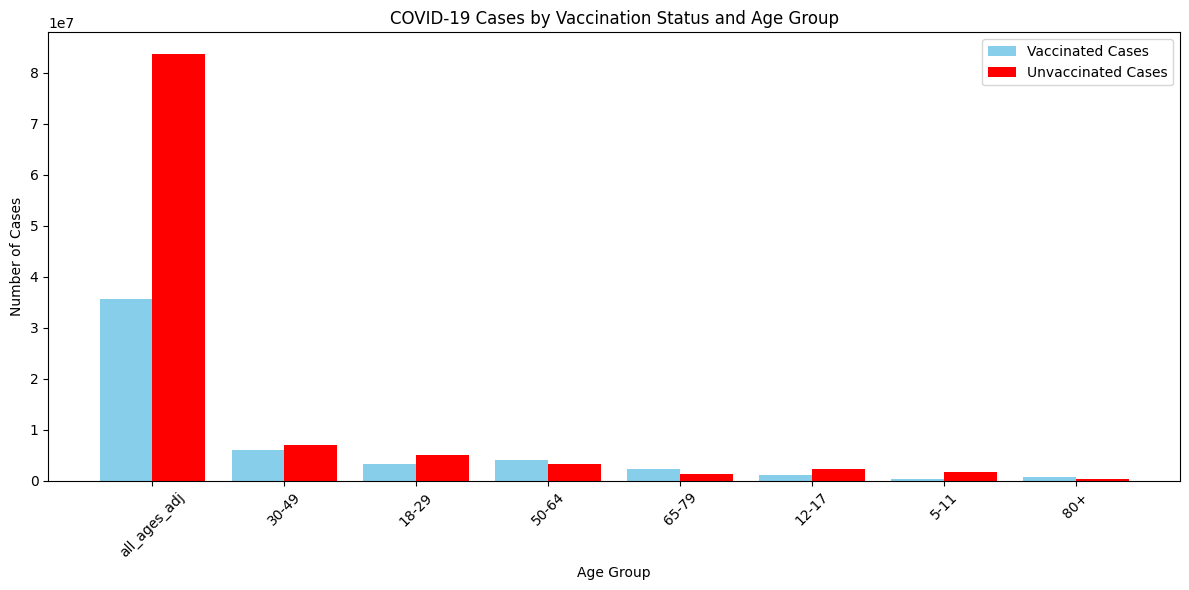

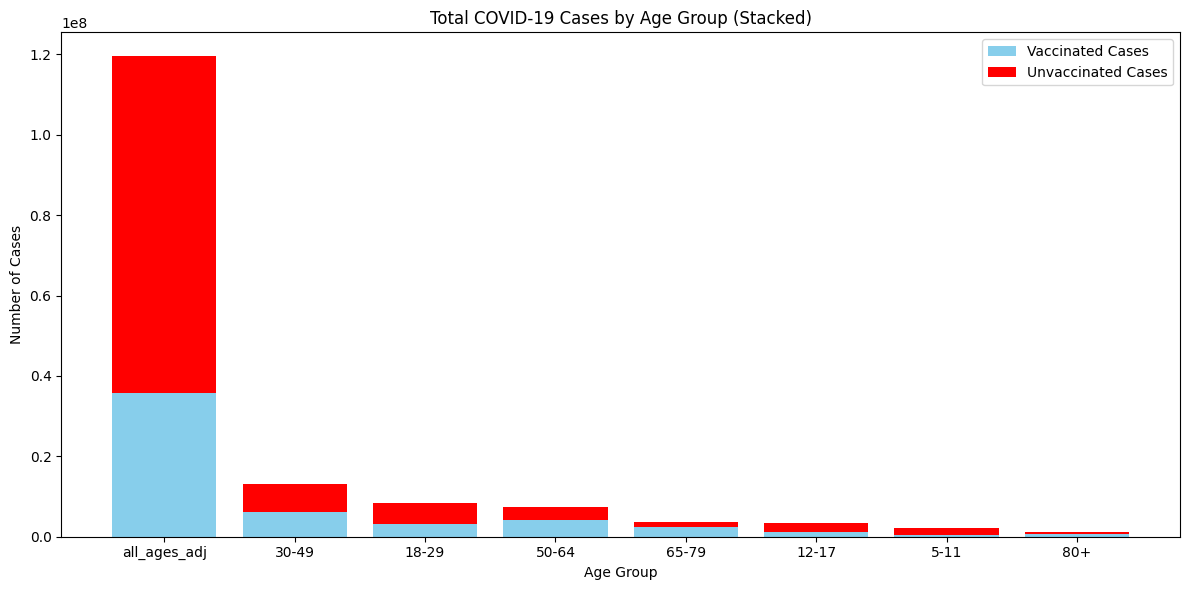

In [4]:
# Define Data for vizualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Cases": [35736157, 6037254, 3235323, 4071401, 2336144, 1064817, 374167, 758672],
    "Unvaccinated_Cases": [83788412, 6934922, 5060862, 3246103, 1365175, 2244912, 1687598, 407531],
    "Total_Cases": [119524569, 12972176, 8296185, 7317504, 3701319, 3309729, 2061765, 1166203],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(12, 6))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Cases"], width=bar_width, label="Vaccinated Cases", color="skyblue")
plt.bar(x + bar_width/2, df["Unvaccinated_Cases"], width=bar_width, label="Unvaccinated Cases", color="red")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("COVID-19 Cases by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Stacked Bar Chart: Total Cases
plt.figure(figsize=(12, 6))
plt.bar(df["Age group"], df["Vaccinated_Cases"], label="Vaccinated Cases", color="skyblue")
plt.bar(df["Age group"], df["Unvaccinated_Cases"], bottom=df["Vaccinated_Cases"], label="Unvaccinated Cases", color="red")
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("Total COVID-19 Cases by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

**TOTAL DEATHS BY AGE GROUPS**

# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')

# Calculate deaths by age group using SQL query
query = """
SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Deaths
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Deaths ASC;
"""

# Execute the query and load results into a DataFrame
deaths_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the result
print(deaths_by_age_group)

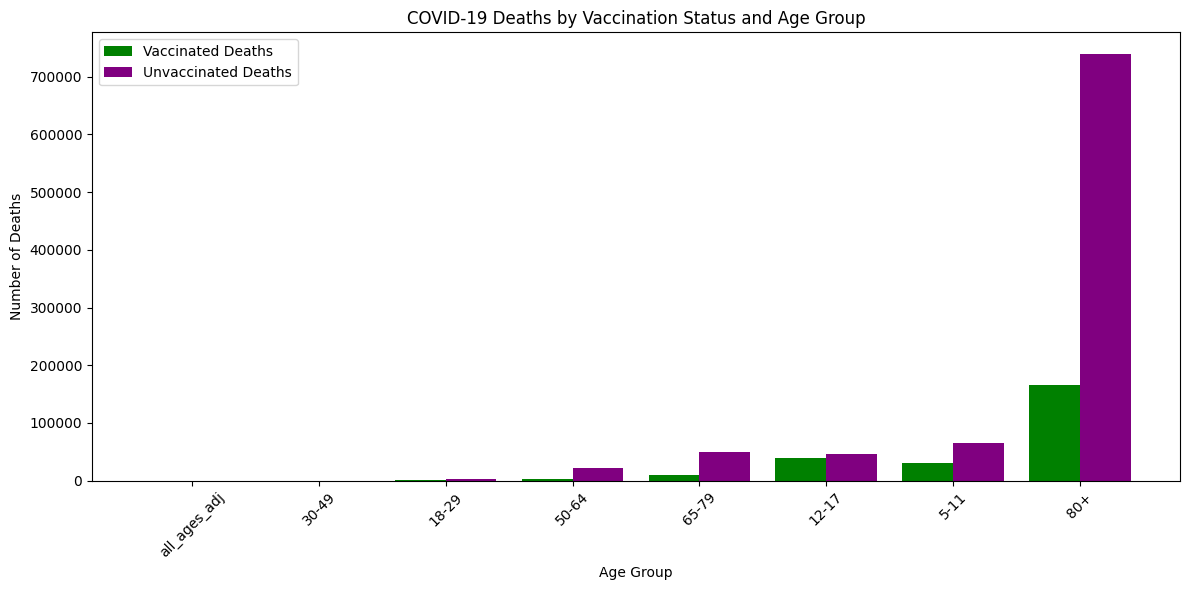

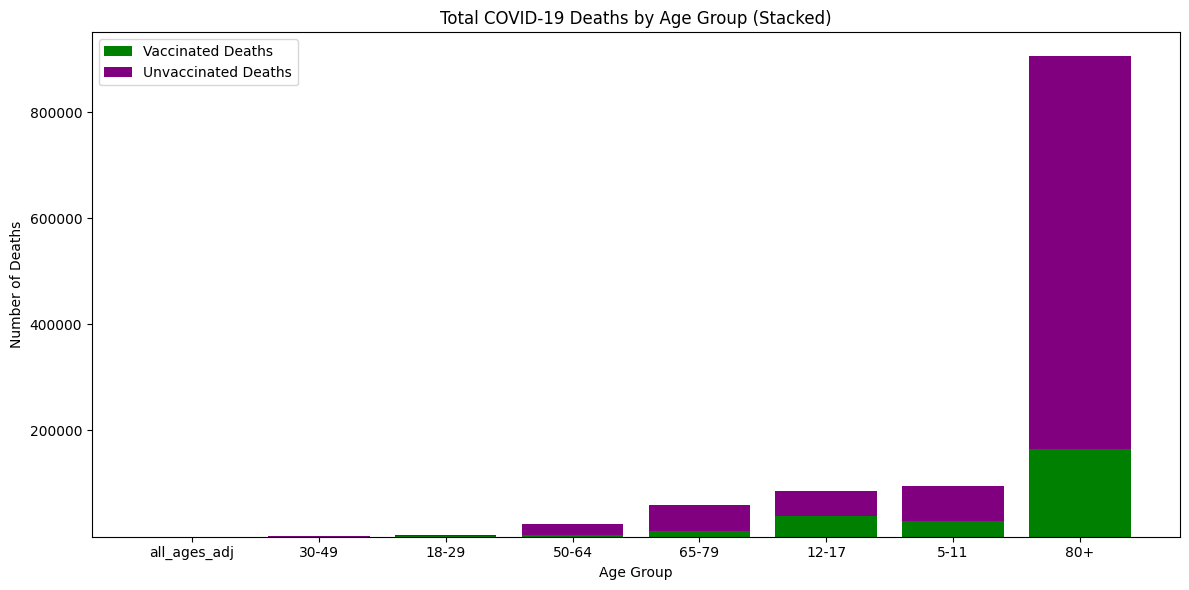

In [8]:
# Define Data for visualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Deaths": [3, 27, 210, 2277, 10328, 39438, 30248, 164958],
    "Unvaccinated_Deaths": [46, 183, 2487, 21013, 49229, 46355, 65686, 739996],
    "Total_Deaths": [49, 210, 2697, 23290, 59557, 85793, 95934, 904954],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(12, 6))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Deaths"], width=bar_width, label="Vaccinated Deaths", color="green")
plt.bar(x + bar_width/2, df["Unvaccinated_Deaths"], width=bar_width, label="Unvaccinated Deaths", color="purple")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("COVID-19 Deaths by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Stacked Bar Chart: Total Cases
plt.figure(figsize=(12, 6))
plt.bar(df["Age group"], df["Vaccinated_Deaths"], label="Vaccinated Deaths", color="green")
plt.bar(df["Age group"], df["Unvaccinated_Deaths"], bottom=df["Vaccinated_Deaths"], label="Unvaccinated Deaths", color="purple")
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("Total COVID-19 Deaths by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

**Total COVID-19 deaths by vaccination status and age group.**

There is a disparity between vaccinated and unvaccinated populations.
About 905,000 deaths occurred across all age groups, with 82% (739,996) among unvaccinated individuals.
The 65-79 and 80+ age groups were at the highest death tolls (95,934 and 85,793 deaths, respectively), driven primarily by unvaccinated individuals.
Deaths among children and adolescents (5-11, and 12-17 years) were minimal, 259 deaths.
Summery (importance of vaccination): Deaths among vaccinated individuals were consistently lower across all age groups, 
reflecting vaccine effectiveness in reducing mortality.